In [2]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from util import *
from layer import *
from optim import *
from net import Net

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
text = ""
ddir = "data/books/witcher_rus/"
for fn in sorted(os.listdir(ddir)):
    if fn.endswith(".gz"):
        with gzip.open(ddir + fn, "rb") as f:
            text += f.read().decode("utf-8").replace("\r", "")
charset = sorted(set(text))
print(charset)
print("%s chars, %s unique" % (len(text), len(charset)))
chidx = {ch: i for i, ch in enumerate(charset)}

raw_data = [chidx[ch] for ch in text]
data = np.array(raw_data, dtype=np.uint8)
dvec = np.eye(len(charset), dtype=np.float64)

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
5088376 chars, 140 unique


In [20]:
batch_size = 200
seqlen = 100

blen = len(data)//batch_size
print("%s chars in sequence" % blen)
bseqdata = data[:blen*batch_size].reshape(batch_size, blen).transpose()
#print(''.join([charset[k] for k in bseqdata.transpose()[-1]]))

25441 chars in sequence


In [5]:
class RNN(Net):
    def __init__(self, sizes):
        self.sizes = sizes
        sx, sh, sy = sizes
        layers = [
            Affine(sx, sh), # W_xh
            Affine(sh, sh), # W_hh
            Affine(sh, sy), # W_hy
            Tanh()
        ]
        links = [
            ((-1, 0), 0), # x
            ((-1, 1), 1), # h_in
            (0, 3),
            (1, 3),
            (3, 2),
            (3, (-1, 1)), # h_out
            (2, (-1, 0)), # y
        ]
        super().__init__(layers, links)
    
    def newstate(self, count):
        return np.zeros((count, self.sizes[1]), dtype=np.float64)

class LSTM(Net):
    def __init__(self, sizes):
        self.sizes = sizes
        sx, sh, sy = sizes
        layers = [
            Affine(sx, sh), #  0, W_xh
            Affine(sh, sy), #  1, W_hy
            Affine(sh, sh), #  2, W_hc
            Tanh(),         #  3, a_hc
            Affine(sh, sh), #  4, W_f
            Sigmoid(),      #  5, a_f
            Affine(sh, sh), #  6, W_i
            Sigmoid(),      #  7, a_i
            Product(),      #  8, p_ih
            Affine(sh, sh), #  9, W_o
            Sigmoid(),      # 10, a_o
            Product(),      # 11, p_cf
            Tanh(),         # 12, a_ch
            Product(),      # 13, p_ho
            Uniform(),      # 14, _xh
            Uniform(),      # 15, _ch
        ]
        links = [
            ((-1, 0), 0), # x
            (0, 14),
            ((-1, 1), 14),# h_in
            ((-1, 2), (8, 0)), # c_in
            (14, 4),
            (4, 5),
            (5, (8, 1)),
            (14, 6),
            (6, 7),
            (7, (13, 0)),
            (14, 2),
            (2, 3),
            (3, (13, 1)),
            (8, 15),
            (13, 15),
            (15, (-1, 2)), # c_out
            (15, 12),
            (12, (11, 0)),
            (14, 9),
            (9, 10),
            (10, (11, 1)),
            (11, (-1, 1)), # h_out
            (11, 1),
            (1, (-1, 0)), # y
        ]
        super().__init__(layers, links)
    
    def newstate(self, count):
        return (
            np.zeros((count, self.sizes[1]), dtype=np.float64),
            np.zeros((count, self.sizes[1]), dtype=np.float64),
        )


![LSTM Route](lstm_route.png)

In [6]:
class Solver:
    def __init__(self, net, **params):
        self.params = params
        self.name = params["name"]
        self.net = net
        
        if params.get("adagrad", False):
            self.optim = Adagrad(
                adagrad=self.net.newgrad(),
                learn_rate=params["learn_rate"],
                reg_rate=params.get("reg_rate", 0)
            )
        else:
            self.optim = SGD(
                learn_rate=params["learn_rate"],
                reg_rate=params.get("reg_rate", 0)
            )
        
        self.loss_history = []
        
    def learn(self, inseq, outseq):
        if inseq.shape[0] != outseq.shape[0]:
            mlen = min((inseq.shape[0], outseq.shape[0]))
            inseq = inseq[0:mlen]
            outseq = outseq[0:mlen]
        seqlen = inseq.shape[0]
        
        loss = 0.0
        cache = []
        
        h = self.net.newstate(self.params["batch_size"])
        if isinstance(h, np.ndarray):
            h = (h,)
        for x, ir in zip(dvec[inseq], outseq):
            ovs, m = self.net.forward((x, *h))
            y, h = ovs[0], ovs[1:]
            smy = softmax(y)
            cache.append((m, smy, ir))
            loss += ce_loss(smy, ir)
        loss /= len(cache)

        grad = self.net.newgrad()
        dh = self.net.newstate(self.params["batch_size"])
        if isinstance(dh, np.ndarray):
            dh = (dh,)
        for m, smy, ir in reversed(cache):
            ovs = self.net.backward(grad, m, (ce_softmax_deriv(smy, ir), *dh))
            dh = ovs[1:]

        self.optim.learn(self.net, grad, norm=len(cache), clip=self.params.get("grad_clip", 0))

        self.loss_history.append(loss)
            
    def sample(self, seed, textlen):
        h = self.net.newstate(1)
        if isinstance(h, np.ndarray):
            h = (h,)
        text = ""
        c = seed
        x = dvec[c].reshape(1, -1)
        text += charset[c]
        for i in range(textlen):
            ovs, _ = self.net.forward((x, *h))
            y, h = ovs[0], ovs[1:]
            smy = softmax(y)
            c = np.random.choice(np.arange(len(charset)), p=smy.reshape(-1))
            text += charset[c]
            x = dvec[c].reshape(1, -1)
        return text

In [7]:
def plot_solvers(sols, red=10, win=100):
    if isinstance(sols, Solver):
        sols = [sols]
        
    plt.subplot(2, 1, 1)
    for sol in sols:
        plt.plot(sol.loss_history[::red], label=sol.name)
    plt.legend()

    plt.subplot(2, 1, 2)
    for sol in sols:
        plt.plot(
            sol.loss_history[-win:], 
            label="%s loss: %.4f" % (sol.name, sol.loss_history[-1])
        )
    plt.legend()
    
    plt.show()

In [8]:
params = {
    "batch_size": batch_size,
    "grad_clip": 5,
    "adagrad": True,
    
    "learn_rate": 1e-1,
    "reg_rate": 0,
}

hidden_size = 100

solvers = []
for Type, name in [(RNN, "RNN"), (LSTM, "LSTM")]:
    solvers.append(Solver(
        Type((len(charset), hidden_size, len(charset))),
        name=name, **params
    ))

In [9]:
epoch = 0
pos = 0

In [ ]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

while not done:
    for sol in solvers:
        sol.learn(bseqdata[pos:pos+seqlen], bseqdata[pos+1:pos+seqlen+1])
    
    pos += seqlen
    if pos >= bseqdata.shape[0] - 1:
        pos = 0
        epoch += 1

print("done")

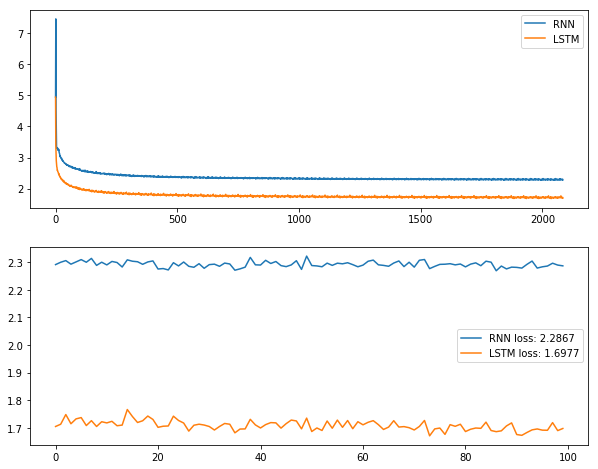

In [23]:
plot_solvers(solvers)

In [17]:
for sol in solvers:
    print("[%s]" % sol.name)
    print(sol.sample(data[pos], 1000))

[RNN]
чавых я спезапысь с уте поних раклазак и чужда, хоки фепольн? Дые. Валозу? Ди  ведрась меетерь она у ва-омы бый дняки отомобира Да бался в штрогядиль! Не Динывашь, этезисто глагорки. И эть бонистол, чецарго нематул кровадь с в товок ивытмолма глазкаватир поз черт ней исприя удем такней, жегилюдее поздахнаестроска не тродстет, дико Люты нил, сови, з поредакаесЖдава рв соло но коволеви: це на поратиры в католь мни. Небарулескаю. Естощешь, и деф -жерьча, дой влишко Эпудик отростили вы а прей отк клогун? Что и напродьшы? Вен. Ты? Ны выскарваростильно разалее ив зогамие робли ты, - отолнилось. - А пухы. Пува. Ты на я поно преко. А камов. Он чту бпопраныт. Промерно намерся быес, пракоробно изполин ваткое гонидм".

Сколаен. У прикоть тестьсть, нико? Одни похнул. - Ведил оначнуми. - Тешался томотсь солаз друлоннонью побдрезнул савак мела рог я дул намкахарь. - Дошли седепоруотопнаяр-кналась ваза, из? Фудетувуютссь стоторц из туласили Азвеста, а и опедьмал дрирпа в сто Боты.

- Я ддемой н

In [ ]:
def cmprnn(net):
    n = 5

    W_xh, W_hh, W_hy = [np.copy(net.nodes[j].W) for j in range(3)]
    
    x = np.random.random(net.sizes[0])
    h = np.random.random(net.sizes[1])

    v = np.dot(x, W_xh) + np.dot(h, W_hh)
    a = np.tanh(v)
    y = np.dot(a, W_hy)

    m = [x, h, v, a, y]

    (_y, _a), _m = net.feed_mem((x.reshape(1, -1), h.reshape(1, -1)))
    print(y - _y.reshape(-1), a - _a.reshape(-1))

    _grad = net.newgrad()

    ey = np.random.random(net.sizes[2])
    eh = np.random.random(net.sizes[1])

    dW_xh, dW_hh, dW_hy = [np.zeros_like(W) for W in [W_xh, W_hh, W_hy]]
    x, h, v, a, y = m

    dW_hy += np.outer(a, ey)
    ea = np.dot(W_hy, ey) + eh
    ev = ea*tanh_deriv(v)
    dW_xh += np.outer(x, ev)
    dW_hh += np.outer(h, ev)
    eh_ = np.dot(W_hh, ev)

    _ex, _eh_ = net.backprop(_grad, _m, (ey.reshape(1, -1), eh.reshape(1, -1)))
    print(_eh_ - eh_)

    for dW, _dW in zip([dW_xh, dW_hh, dW_hy], [_grad.params[j].W for j in range(3)]):
        print(dW - _dW)

    learning_rate = 1e-1

    for W, dW in zip([W_xh, W_hh, W_hy], [dW_xh, dW_hh, dW_hy]):
        dW /= n
        np.clip(dW, -5, 5, out=dW)
        W -= learning_rate*dW

    _optim = SGD(learn_rate=learning_rate)
    _optim.learn(net, _grad, norm=n, clip=5)
    
    for W, _W in zip([W_xh, W_hh, W_hy], [net.nodes[j].W for j in range(3)]):
        print(W - _W)
    
cmprnn(net)

In [4]:
charset = sorted(set("".join(charset).lower()))
print(charset)
chidx = {ch: i for i, ch in enumerate(charset)}
chvec = {ch: np.array([chidx[ch] == i for i in range(len(charset))], dtype=np.float64) for ch in charset}
for ch in charset:
    if ch.islower():
        chidx[ch.upper()] = chidx[ch]
        chvec[ch.upper()] = chvec[ch]